# ABC calibration of $I_\text{CaL}$ in Nygren model to unified dataset.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.29.1


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Li1997]
 - Activation time constant [Li1997]
 - Steady-state inactivation [Li1997]
 - Inactivation time constant (fast+slow) [Li1997]
 - Recovery time constant (fast+slow) [Li1997]

In [4]:
from experiments.ical_li import (li_act_and_tau, # combines steady-state activation and time constant
                                 li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

In [5]:
modelfile = 'models/nygren_ical.mmt'

Plot steady-state and time constant functions of original model

In [6]:
from ionchannelABC.visualization import plot_variables

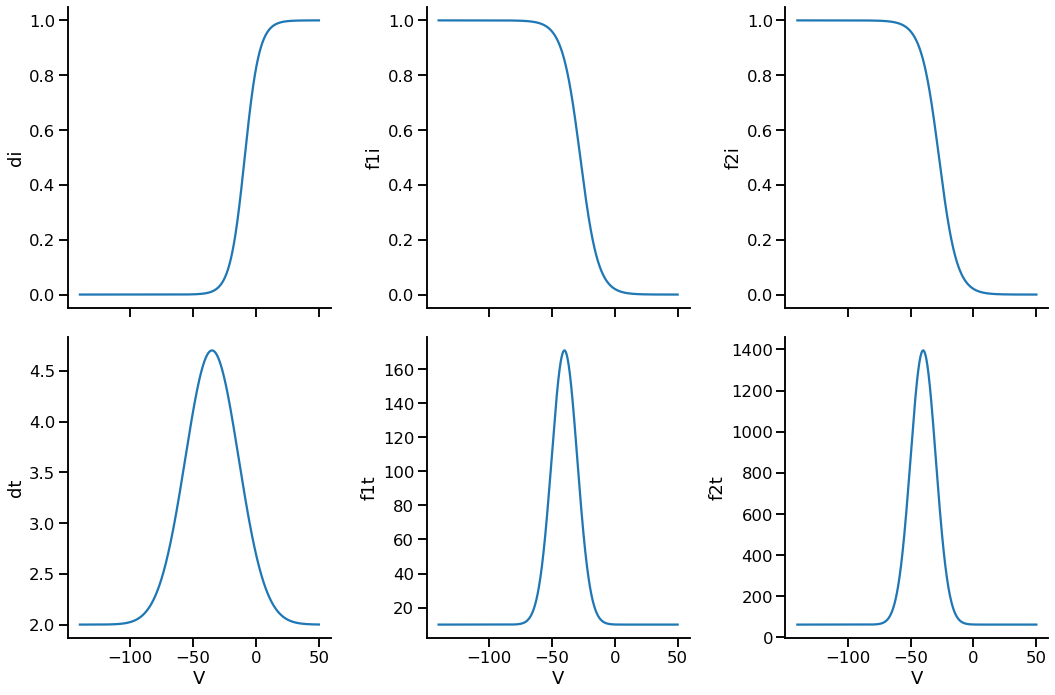

In [11]:
sns.set_context('talk')

V = np.arange(-140, 50, 0.01)

nyg_par_map = {'di': 'ical.d_inf',
            'f1i': 'ical.f_inf',
            'f2i': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'f1t': 'ical.tau_f_1',
            'f2t': 'ical.tau_f_2'}

f, ax = plot_variables(V, nyg_par_map, 'models/nygren_ical.mmt', figshape=(3,2))

# Activation gate ($d$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [7]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act_and_tau)

In [8]:
assert len(observations)==len(summary_statistics(model({})))

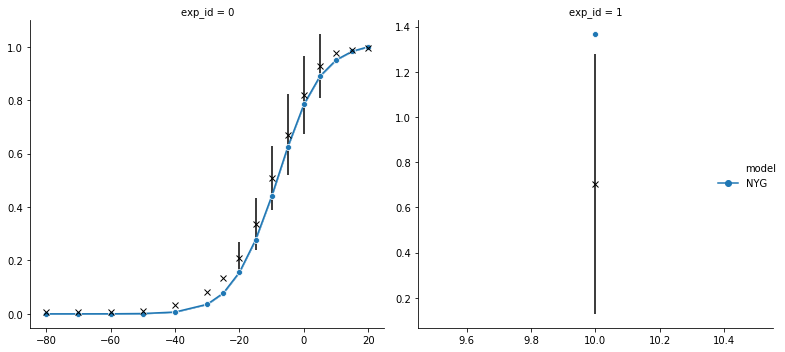

In [9]:
g = plot_sim_results(modelfile,
                     li_act_and_tau)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [10]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (-100, 100),
          'ical.p5': (0, 50),
          'log_ical.p6': (-7, 3)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [11]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ical_dgate_unified.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

Test theoretical number of particles for approximately 2 particles per dimension in the initial sampling of the parameter hyperspace.

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


Initialise ABCSMC (see pyABC documentation for further details).

IonChannelDistance calculates the weighting applied to each datapoint based on the experimental variance.

In [16]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.2287454676498424, '1': 1.2287454676498424, '2': 1.2287454676498424, '3': 1.2287454676498424, '4': 1.2287454676498424, '5': 1.2287454676498424, '6': 1.2287454676498424, '7': 1.0293830767146164, '8': 0.6283247351374927, '9': 0.5133263088125923, '10': 0.4040167399213943, '11': 0.41888315675832816, '12': 0.5146915383573082, '13': 1.2287454676498424, '14': 1.2287454676498424, '15': 1.2287454676498424, '16': 1.2039197677998434}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [17]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [18]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-12-19 11:00:24.455776, end_time=None)>


Run calibration with stopping criterion of particle 1\% acceptance rate.

In [19]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 100.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.
DEBUG:ABC:Total samples up to t = 0: 3870.
INFO:ABC:Acceptance rate: 2000 / 3870 = 5.1680e-01.
DEBUG:Epsilon:new eps, t=1, eps=2.4771344310985395
INFO:ABC:t: 1, eps: 2.4771344310985395.
DEBUG:ABC:Now submitting population 1.
DEBUG:ABC:Population 1 done.
DEBUG:ABC:Total samples up to t = 1: 8143.
INFO:ABC:Acceptance rate: 2000 / 4273 = 4.6806e-01.
DEBUG:Epsilon:new eps, t=2, eps=1.4772041297741292
INFO:ABC:t: 2, eps: 1.4772041297741292.
DEBUG:ABC:Now submitting population 2.
DEBUG:ABC:Population 2 done.
DEBUG:ABC:Total samples up to t = 2: 12559.
INFO:ABC:Acceptance rate: 2000 / 4416 = 4.5290e-01.
DEBUG:Epsilon:new eps, t=3, eps=1.2694970639420828
INFO:ABC:t: 3, eps: 1.2694970639420828.
DEBUG:ABC:Now submitting population 3.
DEBUG:ABC:Population 3 done.
DEBUG:ABC:Total samples up to t = 3: 17878.
INFO:ABC:Acceptance rate: 2000 / 5319 = 3.7601e-01.
DEBUG:Epsilon:new eps, t=4, eps=1.08252089407011

## Analysis of results

In [20]:
history = History(db_path)

In [18]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-10-18 09:52:37.719386, end_time=2019-10-18 11:12:07.102511)>]

In [21]:
df, w = history.get_distribution(m=0)

In [22]:
df.describe()

name,ical.p1,ical.p2,ical.p4,ical.p5,log_ical.p3,log_ical.p6
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,8.972873,7.406125,-15.756052,27.033101,-3.786519,-3.318784
std,1.482695,0.584719,56.432013,13.808743,1.803069,0.761812
min,1.001454,6.497247,-99.977619,0.042776,-6.999965,-6.988451
25%,8.992030,7.045829,-59.606754,15.427261,-5.213934,-3.061983
50%,9.449669,7.285113,-34.095786,27.759353,-3.749400,-3.027593
75%,9.791596,7.539963,35.167693,39.155596,-2.627287,-3.019839
max,11.338545,10.611427,99.869196,49.917177,2.932878,-2.727029


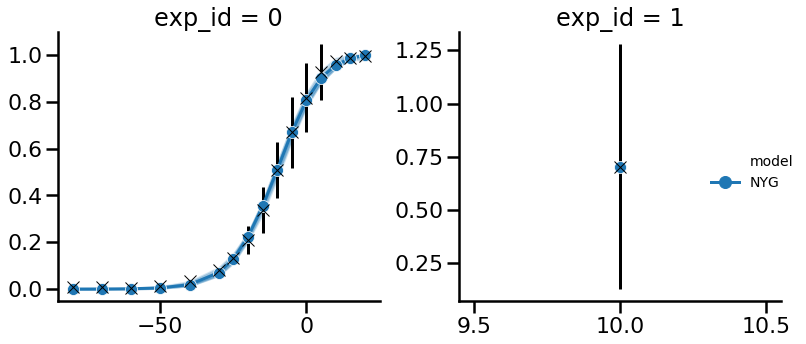

In [23]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     df=df, w=w)

plt.tight_layout()

In [24]:
import pandas as pd
N = 100

nyg_par_samples = df.sample(n=N, weights=w, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

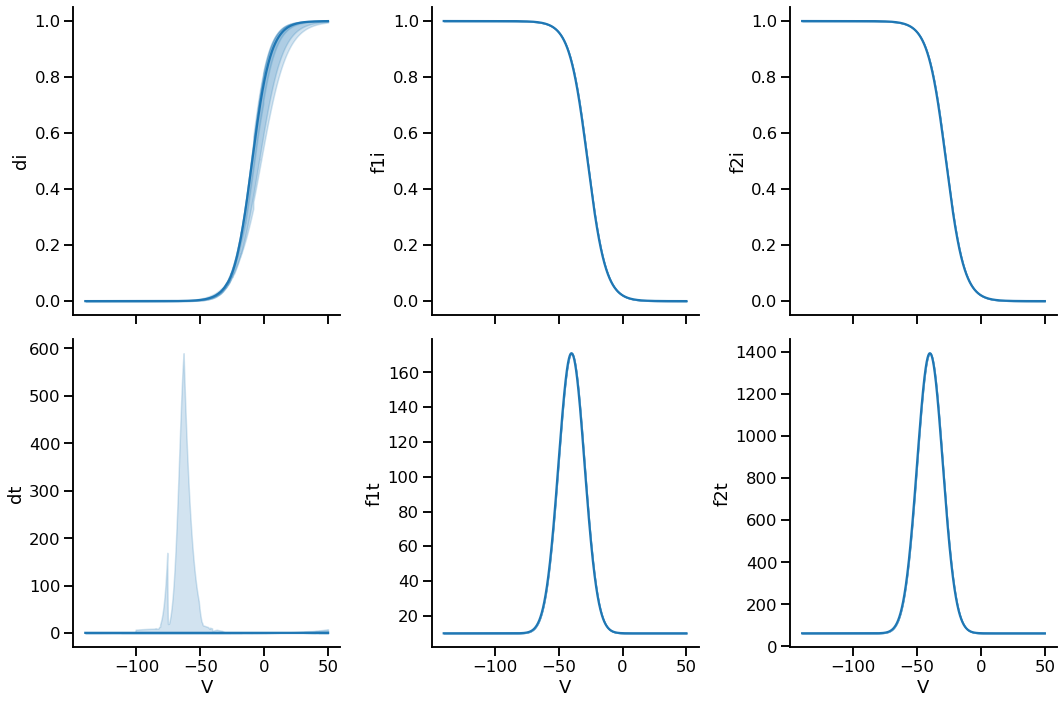

In [26]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

V = np.arange(-140, 50, 0.01)

nyg_par_map = {'di': 'ical.d_inf',
            'f1i': 'ical.f_inf',
            'f2i': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'f1t': 'ical.tau_f_1',
            'f2t': 'ical.tau_f_2'}

f, ax = plot_variables(V, nyg_par_map, 
                       'models/nygren_ical.mmt', 
                       [nyg_par_samples],
                       figshape=(3,2))

In [27]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [28]:
m,_,_ = myokit.load(modelfile)

In [29]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

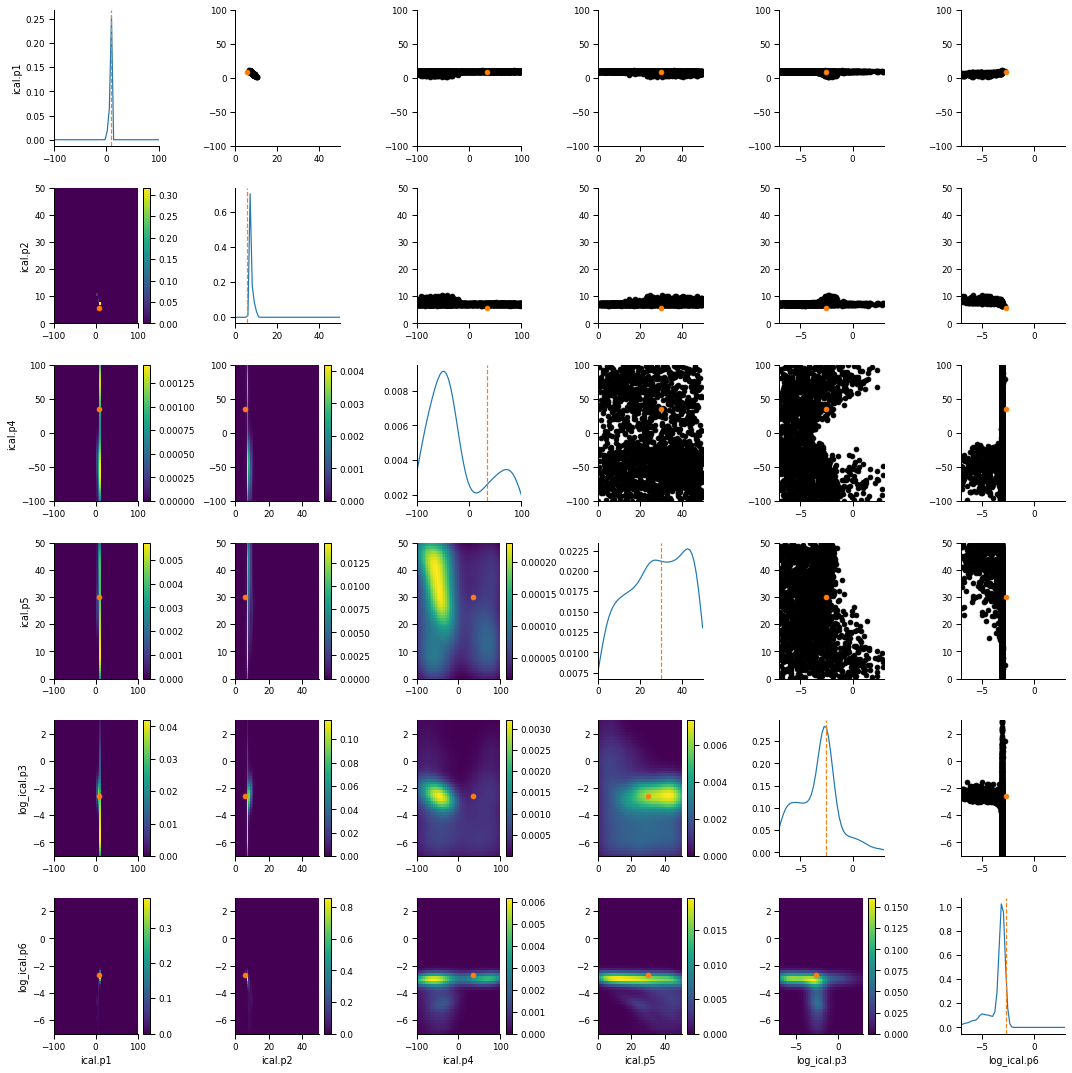

In [30]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)